# Email content identifier

### Background

For my final Thinkful capstone I built an email content identifier that relies on NPL and different APIs to detect what products each document mentions.

Having access to this technology will enable my company to do a few things:

- Understand which companies are related
  - E.g. Both Allen Edmonds and Nike talk a lot about shoes
- Help our users plan their merchandising calendar
  - E.g. “Ohh, we’ve promoted shirts a lot in Q1, we should switch things up. Look, our top competitor is focused on jeans, should we try that?”
- Allow our users to understand seasonality
  - E.g. When does my top competitor start promoting scarves and jackets?

### About the code

The classifier was built into [it's own API](https://github.com/carlsednaoui/thinkful-data-science/blob/master/coursework/final_capstone/product_classifier_api.py).

The API uses the following:

- An input "categories" table
- An input email (subject, full text, and raw HTML)

Given the above inputs, the API will:

- Clean up the text using NPL
  - Remove special characters
  - Remove non ASCII characters
  - Normalize the text
  - Extract alphanumeric values
  - Ignore any verbs (watch the accessory is not the same as watch the verb)
  - Lemmatize words
- Fetch all the images in the email
- Remove any small-ish images (non relevant)
- Use Google Vision API for OCR
- Use Google Vision API for image labeling

From there the API creates a score for each category found depending on how strong the signal for such category is, based on the subject, the body of the email, the images text, and the images content.

The results is then returned.

In [22]:
import numpy as np
import pandas as pd
import ast
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
df = pd.read_csv("./data/companies_to_productize.csv", encoding="ISO-8859-1", dtype=str)
categories = []

with open("saved_productization_results.txt", "r") as f:
    for line in f.readlines():
        categories.append(line)
df["products"] = categories

def find_top_product(products):
    classification = ast.literal_eval(products)["results"]
    
    if len(classification) > 0:
        # only grab the top product category
        # most_specific = classification[0][0].split("> ")[-1]
        # return most_specific
        results = []
        for product in classification:
            # grab the most specific product category for each of the results
            # results.append((product[0].split(">")[-1].strip(), product[1]))
            results.append((product[0], product[1]))
        return results
    else:
        return None
    

df["product_scores"] = df["products"].apply(lambda x: find_top_product(x))

In [24]:
def aggregate_company_scores(emails):

    company_categories = {}
    
    for email_score in emails["product_scores"]:
        if email_score != None:
            for score in email_score:
                product = score[0]
                value = score[1]
                
                if product in company_categories:
                    company_categories[product] = company_categories[product] + value
                else:
                    company_categories[product] = value
    categories = list(company_categories.items())
    categories.sort(key=lambda tup: tup[0])
    return(categories)
        
    

companies = df.groupby("name")
dataframe_arr = []

for company, group in companies:    
    score = aggregate_company_scores(group)
    for s in score:
        dataframe_arr.append({"company": company.split(" ")[0], "label": s[0], "score": s[1]})

score_df = pd.DataFrame(dataframe_arr)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


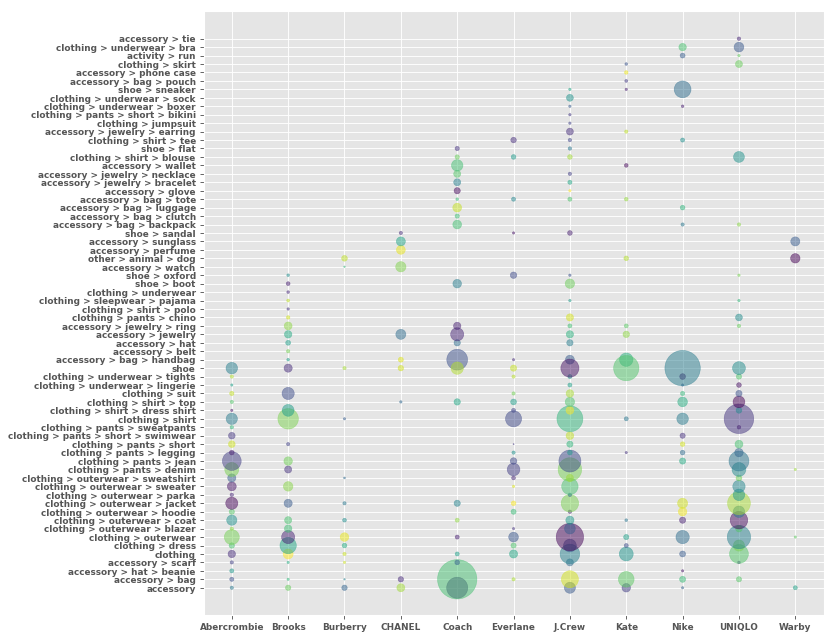

In [25]:
plt.style.use('ggplot')

x = score_df["company"].values
y = score_df["label"].values
size = score_df["score"].values * 10

font = {'family' : 'helvetica',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
plt.figure(figsize=(10, 10), dpi= 80)
plt.scatter(x, y, s=size, c=np.random.rand(len(x)), alpha=0.5)
plt.show()

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


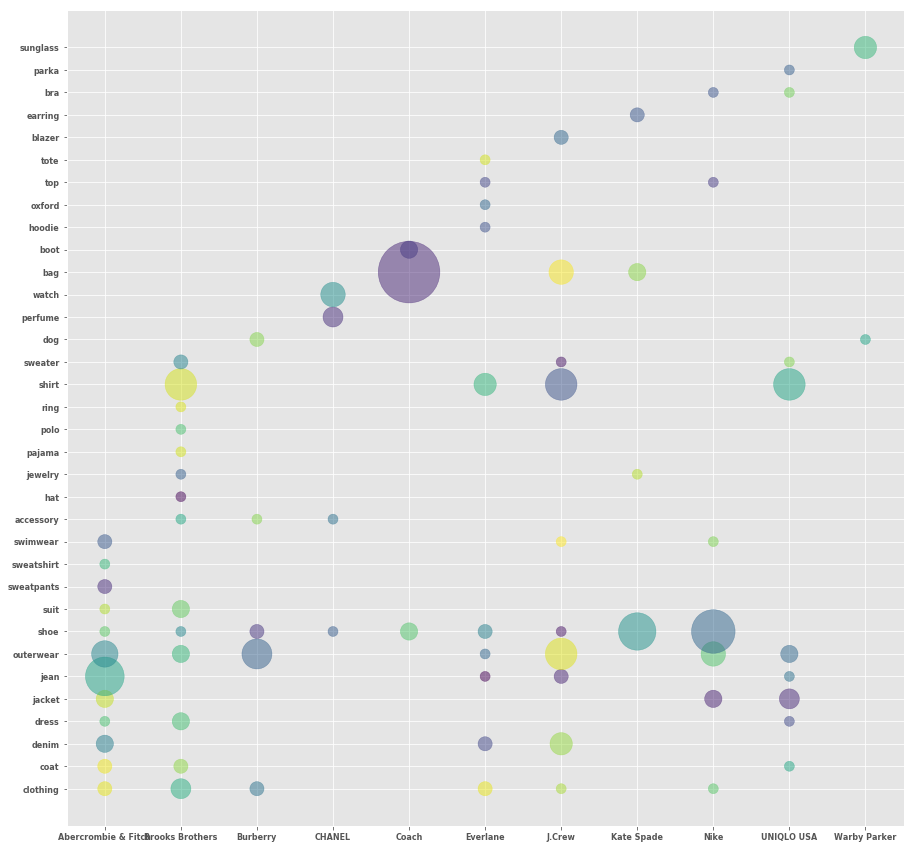

<Figure size 800x800 with 0 Axes>

In [34]:
# we can also simplify this a bit

def find_top_product(products):
    prod = ast.literal_eval(products)["results"]
    if len(prod) > 0:
        most_specific = prod[0][0].split("> ")[-1]
        return most_specific
    else:
        return None
    
df["top_product"] = df["products"].apply(lambda x: find_top_product(x))

results = df.groupby(["name", "top_product"]).company_id.count().reset_index()
x = results["name"]
y = results["top_product"]
area = results["company_id"] * 100
colors = np.random.rand(len(x))

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.figure(figsize=(10, 10), dpi= 80)
plt.show()

In [26]:
# we can now see which companies are closely related

pivot_df = score_df.pivot(index="company", values="score", columns="label").fillna(0)
kmeans = KMeans(n_clusters=4, random_state=100).fit(pivot_df)

company_similarity_matrix = pd.DataFrame(cosine_similarity(pivot_df, pivot_df))
company_similarity_matrix.columns = list(pivot_df.index)
company_similarity_matrix.index = list(pivot_df.index)
company_similarity_matrix

,Abercrombie,Brooks,Burberry,CHANEL,Coach,Everlane,J.Crew,Kate,Nike,UNIQLO,Warby
Abercrombie,1.000000,0.530510,0.467505,0.048685,0.069413,0.624969,0.859448,0.271778,0.366393,0.781521,0.037397
Brooks,0.530510,1.000000,0.448068,0.080337,0.056147,0.767647,0.740222,0.192575,0.235209,0.783039,0.023103
Burberry,0.467505,0.448068,1.000000,0.136555,0.132308,0.330151,0.583194,0.223556,0.245895,0.500881,0.338721
CHANEL,0.048685,0.080337,0.136555,1.000000,0.314349,0.028034,0.116819,0.271930,0.153138,0.024437,0.314947
Coach,0.069413,0.056147,0.132308,0.314349,1.000000,0.053081,0.258035,0.479128,0.118790,0.050347,0.035920
Everlane,0.624969,0.767647,0.330151,0.028034,0.053081,1.000000,0.827512,0.192930,0.250144,0.814813,0.033602
J.Crew,0.859448,0.740222,0.583194,0.116819,0.258035,0.827512,1.000000,0.382402,0.374485,0.868516,0.051245
Kate,0.271778,0.192575,0.223556,0.271930,0.479128,0.192930,0.382402,1.000000,0.846506,0.211566,0.036808
Nike,0.366393,0.235209,0.245895,0.153138,0.118790,0.250144,0.374485,0.846506,1.000000,0.300753,0.006652
UNIQLO,0.781521,0.783039,0.500881,0.024437,0.050347,0.814813,0.868516,0.211566,0.300753,1.000000,0.024121


In [27]:
# we can also find similar emails (from other companies)

def grab_email_scores(email):
    
    company_categories = {}
        
    email_score = email["product_scores"]
    if email_score != None:
        for score in email_score:
            product = score[0]
            value = score[1]

            if product in company_categories:
                company_categories[product] = company_categories[product] + value
            else:
                company_categories[product] = value
    categories = list(company_categories.items())

    result = []
    for cat in categories:
        result.append([email["name"], email.guid, cat[0], cat[1]])
    return(result)

In [28]:
emails = []
for index, row in df.iterrows():
    emails.extend(grab_email_scores(row))

emails_df = pd.DataFrame(emails, columns=["company", "guid", "category", "score"])
email_pivot = emails_df.pivot(index="guid", columns="category", values="score").fillna(0)

email_similarity_matrix = pd.DataFrame(cosine_similarity(email_pivot, email_pivot))
email_similarity_matrix.columns = list(email_pivot.index)
email_similarity_matrix.index = list(email_pivot.index)

In [29]:
def find_first_non_company_email(guid):
    emails = email_similarity_matrix.loc[guid].sort_values(ascending=False).index
    company = emails_df[emails_df["guid"] == guid]["company"].iloc[0]

    for email in emails:
        email_company = emails_df[emails_df["guid"] == email]["company"].iloc[0]
        if company != email_company:
            return email

find_first_non_company_email("1b839bba-c8b6-0289-5d30-fc145bd57b34")

'2d390a9c-9c7e-0752-301b-558e3f4afd6f'